## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA

Fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [ ]:
# Check the GPU
!nvidia-smi

Sun Apr  6 01:10:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.9 MB/s eta 0:00:00


In [ ]:

!pip install torchvision tensorboard

Make sure to install `diffusers` from `main`.

In [ ]:

!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
ls -l content/custom_dataset/frog/

total 0


Download diffusers SDXL DreamBooth training script.

## Auto-generate caption.json based on filenames

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2025-04-06 01:14:33--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84961 (83K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.97K  --.-KB/s    in 0.002s  

2025-04-06 01:14:33 (44.9 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84961/84961]



## Dataset

**Option 1:** upload example images from your local files:

In [ ]:
from google.colab import drive
import os
import json
import shutil

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define directories
base_dir = "/content/custom_dataset"
instance_dir = os.path.join(base_dir, "instance_images")
class_dir = os.path.join(base_dir, "class_images")
metadata_dir = os.path.join(base_dir, "metadata")  # New folder for captions
style_name = "yarn art style"
subject_token = "TOK"

In [ ]:
ls -l drive/MyDrive/'Data 298B'/'SDXL_Dreambooth_lora_character consistency'/'yarn style'/

total 13933
-rw------- 1 root root 422372 Jan  1  1980 10.png
-rw------- 1 root root 458794 Jan  1  1980 11.png
-rw------- 1 root root 454266 Jan  1  1980 12.png
-rw------- 1 root root 540507 Jan  1  1980 13.png
-rw------- 1 root root 608016 Jan  1  1980 14.png
-rw------- 1 root root 482670 Jan  1  1980 15.png
-rw------- 1 root root 602750 Jan  1  1980 16.png
-rw------- 1 root root 575395 Jan  1  1980 17.png
-rw------- 1 root root 430709 Jan  1  1980 18.png
-rw------- 1 root root 415881 Jan  1  1980 19.png
-rw------- 1 root root 528247 Jan  1  1980 1.png
-rw------- 1 root root 497464 Jan  1  1980 20.png
-rw------- 1 root root 490384 Jan  1  1980 21.png
-rw------- 1 root root 484310 Jan  1  1980 22.png
-rw------- 1 root root 497799 Jan  1  1980 23.png
-rw------- 1 root root 366986 Jan  1  1980 24.png
-rw------- 1 root root 443700 Jan  1  1980 25.png
-rw------- 1 root root 610333 Jan  1  1980 26.png
-rw------- 1 root root 609312 Jan  1  1980 27.png
-rw------- 1 root root 540148 Jan  1  1

In [ ]:
# Define Google Drive source paths (update these to your actual paths)
face_source = "drive/MyDrive/Data 298B/SDXL_Dreambooth_lora_character consistency/frog/"      # Folder with 5-10 face images
style_source = "drive/MyDrive/Data 298B/SDXL_Dreambooth_lora_character consistency/yarn style/"  # Folder with yarn art style images

In [ ]:
# Create directories
os.makedirs(instance_dir, exist_ok=True)
os.makedirs(class_dir, exist_ok=True)
os.makedirs(metadata_dir, exist_ok=True)

In [ ]:
# Copy images from Google Drive
print(f"Copying face images from {face_source}...")
shutil.copytree(face_source, instance_dir, dirs_exist_ok=True)
print(f"Copying style images from {style_source}...")
shutil.copytree(style_source, class_dir, dirs_exist_ok=True)

Copying face images from drive/MyDrive/Data 298B/SDXL_Dreambooth_lora_character consistency/frog/...
Copying style images from drive/MyDrive/Data 298B/SDXL_Dreambooth_lora_character consistency/yarn style/...


'/content/custom_dataset/class_images'

In [ ]:
# Generate captions for instance images
instance_captions = {}
for filename in os.listdir(instance_dir):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
        caption = f"{subject_token}, a frog in {style_name}"
        instance_captions[filename] = caption

In [ ]:
# Generate captions for class images
class_captions = {}
for filename in os.listdir(class_dir):
    if filename.lower().endswith((".png", ".jpg", ".jpeg", ".webp")):
        subject = os.path.splitext(filename)[0].replace(", yarn art style", "").strip()
        caption = f"{subject} in {style_name}"
        class_captions[filename] = caption

In [ ]:
# Save captions in metadata folder
with open(os.path.join(metadata_dir, "instance_captions.json"), "w") as f:
    json.dump(instance_captions, f, indent=4)
with open(os.path.join(metadata_dir, "class_captions.json"), "w") as f:
    json.dump(class_captions, f, indent=4)

In [ ]:

print(f"✅ Dataset prepared at {base_dir}")
print(f"Instance images: {len(instance_captions)} files")
print(f"Class images: {len(class_captions)} files")

✅ Dataset prepared at /content/custom_dataset
Instance images: 6 files
Class images: 28 files


### File path:

##
content/custom_dataset/yarn style

In [ ]:
!ls -l /content/custom_dataset/instance_images
!ls -l /content/custom_dataset/class_images

total 18884
-rw------- 1 root root 1953270 Apr  5 12:35 1.png
-rw------- 1 root root 3965343 Apr  6 00:47 2.png
-rw------- 1 root root 4100421 Apr  6 00:47 3.png
-rw------- 1 root root 3042327 Apr  6 01:02 4.png
-rw------- 1 root root 3068565 Apr  6 01:00 5.png
-rw------- 1 root root 3190844 Apr  6 01:05 6.png
total 13984
-rw------- 1 root root 422372 Jan  1  1980 10.png
-rw------- 1 root root 458794 Jan  1  1980 11.png
-rw------- 1 root root 454266 Jan  1  1980 12.png
-rw------- 1 root root 540507 Jan  1  1980 13.png
-rw------- 1 root root 608016 Jan  1  1980 14.png
-rw------- 1 root root 482670 Jan  1  1980 15.png
-rw------- 1 root root 602750 Jan  1  1980 16.png
-rw------- 1 root root 575395 Jan  1  1980 17.png
-rw------- 1 root root 430709 Jan  1  1980 18.png
-rw------- 1 root root 415881 Jan  1  1980 19.png
-rw------- 1 root root 528247 Jan  1  1980 1.png
-rw------- 1 root root 497464 Jan  1  1980 20.png
-rw------- 1 root root 490384 Jan  1  1980 21.png
-rw------- 1 root root 4843

Preview the images:

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

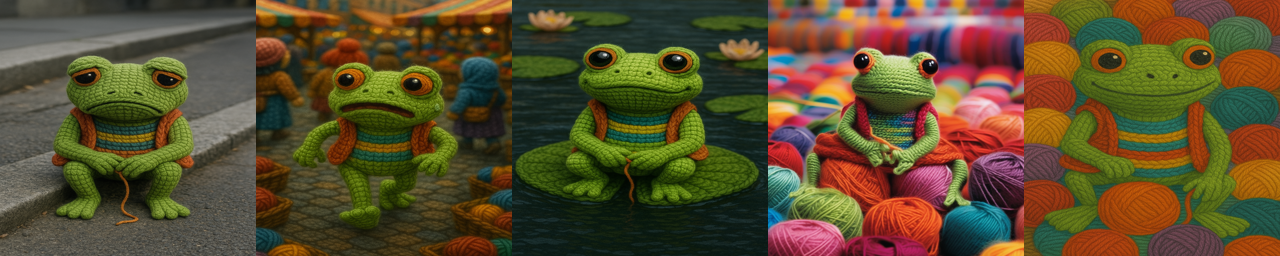

In [ ]:
import glob

# change path to display images from your local dir
img_paths = '/content/custom_dataset/instance_images/*.png'
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

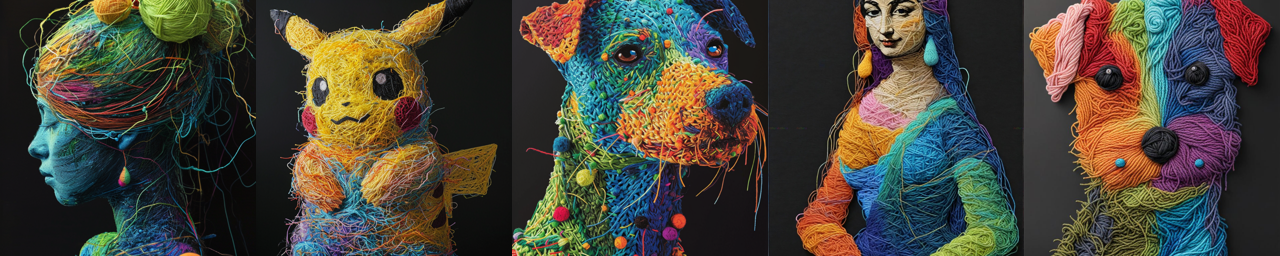

In [ ]:
import glob

# change path to display images from your local dir
img_paths = '/content/custom_dataset/class_images/*.png'
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [ ]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
#print(local_dir)

content/custom_dataset/frog/


Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [ ]:
import json

caption_prefix = "a photo of yarn art style frog, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

Free some memory:

In [ ]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [ ]:
!pip install huggingface_hub
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.5 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login,notebook_login
import tqdm as notebook_tqdm

### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [ ]:
!pip install datasets -q

In [ ]:
import requests

url = "https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py"
response = requests.get(url)
with open("train_dreambooth_lora_sdxl.py", "wb") as f:
    f.write(response.content)

print("Script downloaded successfully!")

Script downloaded successfully!


In [ ]:
!pip install -q accelerate diffusers transformers peft datasets bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
!pip install bitsandbytes

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [ ]:
#!python train_dreambooth_lora_sdxl.py --help

In [ ]:
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --instance_data_dir="/content/custom_dataset/instance_images/" \
  --class_data_dir="/content/custom_dataset/class_images" \
  --output_dir="/content/drive/MyDrive/sdxl_dreambooth_lora_frog_v2" \
  --instance_prompt="a photo of TOK frog" \
  --class_prompt="a frog in yarn art style" \
  --with_prior_preservation \
  --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=1000 \
  --checkpointing_steps=100 \
  --mixed_precision="fp16" \
  --gradient_checkpointing \
  --use_8bit_adam \
  --seed=42 \
  --rank=16

2025-04-06 01:19:57.796008: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-06 01:19:57.812318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743902397.835234    6374 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743902397.842089    6374 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-06 01:19:57.864566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr